In [185]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import style
from collections import Counter
import re
from geotext import GeoText
from wordcloud import WordCloud
from PIL import Image
style.use('fivethirtyeight')

In [186]:
# constants
DATA_PATH = '../data/'
JOBS_PATH = DATA_PATH + 'jobs/'
IMG_PATH = DATA_PATH + 'images/'

In [187]:
try:
    df = pd.read_pickle(JOBS_PATH + 'monster-jobs.pickle')
except FileNotFoundError:
    df = pd.read_csv(JOBS_PATH + 'monster-jobs.csv')
    df.to_pickle(JOBS_PATH + 'monster-jobs.pickle')

In [188]:
df.head()

,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,organization,page_url,salary,sector,uniq_id
0,United States of America,US,NaN,No,jobs.monster.com,TeamSoft is seeing an IT Support Specialist to...,IT Support Technician Job in Madison,Full Time Employee,"Madison, WI 53702",NaN,http://jobview.monster.com/it-support-technici...,NaN,IT/Software Development,11d599f229a80023d2f40e7c52cd941e
1,United States of America,US,NaN,No,jobs.monster.com,The Wisconsin State Journal is seeking a flexi...,Business Reporter/Editor Job in Madison,Full Time,"Madison, WI 53708",Printing and Publishing,http://jobview.monster.com/business-reporter-e...,NaN,NaN,e4cbb126dabf22159aff90223243ff2a
2,United States of America,US,NaN,No,jobs.monster.com,Report this job About the Job DePuy Synthes Co...,Johnson & Johnson Family of Companies Job Appl...,"Full Time, Employee",DePuy Synthes Companies is a member of Johnson...,Personal and Household Services,http://jobview.monster.com/senior-training-lea...,NaN,NaN,839106b353877fa3d896ffb9c1fe01c0
3,United States of America,US,NaN,No,jobs.monster.com,Why Join Altec? If you’re considering a career...,Engineer - Quality Job in Dixon,Full Time,"Dixon, CA",Altec Industries,http://jobview.monster.com/engineer-quality-jo...,NaN,Experienced (Non-Manager),58435fcab804439efdcaa7ecca0fd783
4,United States of America,US,NaN,No,jobs.monster.com,Position ID# 76162 # Positions 1 State CT C...,Shift Supervisor - Part-Time Job in Camphill,Full Time Employee,"Camphill, PA",Retail,http://jobview.monster.com/shift-supervisor-pa...,NaN,Project/Program Management,64d0272dc8496abfd9523a8df63c184c


In [189]:
descriptions = df['job_description']
job_titles = df['job_title']

In [190]:
stop_words = set(stopwords.words('english'))
additional_stop_words = set(['Job', 'monster', 'monster.com','Monstercom', 'MONS_LOG_VARS', 'var', 'ejb_header', 'JobID'])
stop_words = stop_words.union(additional_stop_words)

In [191]:
def get_column_word_counter(column):
    all_tokens = []
    location_tokens = []
    for elm in column:
        tokens = word_tokenize(elm)
        for token in tokens:
            stripped = re.sub(r'\W+', '', token)
            if stripped not in stop_words:
                if len(stripped) > 0:
                    loc = GeoText(stripped)
                    if(len(loc.cities) > 0):
                        location_tokens.append(stripped)
                    else:
                        all_tokens.append(stripped)  
    return Counter(all_tokens), Counter(location_tokens), all_tokens, location_tokens    

In [192]:
jt_all_words_counter,jt_loc_words_counter, jt_all, jt_loc = get_column_word_counter(job_titles)
#jt_all_common_words.most_common(100)

In [193]:
#jt_loc_common_words.most_common(100)

In [194]:
def make_US_word_cloud(locations, stop_words):
    # https://lollyjane.com/wp-content/uploads/2014/05/free-united-states-silhouette.jpg
    us_img = np.array(Image.open('../data/images/us-stencil.png'))
    
    wc = WordCloud(background_color="white", max_words=2000, mask=us_img,
                  stopwords=stop_words)
    wc.generate_from_frequencies(locations)
    wc.to_file(IMG_PATH + 'location-word-cloud.png')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

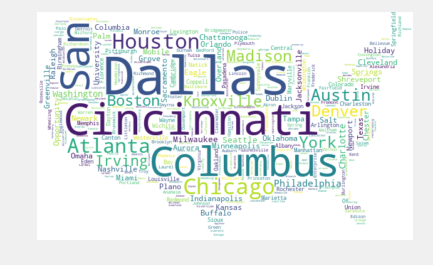

In [195]:
make_US_word_cloud(jt_loc_words_counter, stop_words)